In [ ]:
import segyio
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from qa_qc_lib.qa_qc_seismic import *

In [ ]:
def generate_random_nonintersecting_polygon(num_sides, min_side_length, max_side_length):
    if num_sides < 3:
        raise ValueError("A polygon must have at least 3 sides.")

    # Generate random side lengths
    side_lengths = np.random.uniform(min_side_length, max_side_length, num_sides)

    # Calculate the total perimeter of the polygon
    total_perimeter = np.sum(side_lengths)

    # Calculate the angles between the sides
    angles = np.random.uniform(0, 360, num_sides)

    # Generate the cumulative angles for vertex positions
    cumulative_angles = np.cumsum(angles)

    # Generate the coordinates of the polygon vertices
    x_coords = total_perimeter * np.cos(np.radians(cumulative_angles))
    y_coords = total_perimeter * np.sin(np.radians(cumulative_angles))

    # Close the polygon
    x_coords = np.append(x_coords, x_coords[0])
    y_coords = np.append(y_coords, y_coords[0])

    # Check if any of the sides intersect, and if so, regenerate the polygon
    for i in range(num_sides):
        x1, y1 = x_coords[i], y_coords[i]
        x2, y2 = x_coords[(i + 1) % num_sides], y_coords[(i + 1) % num_sides]
        for j in range(i + 2, num_sides):
            x3, y3 = x_coords[j], y_coords[j]
            x4, y4 = x_coords[(j + 1) % num_sides], y_coords[(j + 1) % num_sides]
            if do_segments_intersect(x1, y1, x2, y2, x3, y3, x4, y4):
                return generate_random_nonintersecting_polygon(num_sides, min_side_length, max_side_length)

    return x_coords, y_coords

def do_segments_intersect(x1, y1, x2, y2, x3, y3, x4, y4):
    # Check if two line segments intersect using the cross product method
    def cross_product(x1, y1, x2, y2):
        return x1 * y2 - x2 * y1

    d1 = cross_product(x4 - x3, y4 - y3, x1 - x3, y1 - y3)
    d2 = cross_product(x4 - x3, y4 - y3, x2 - x3, y2 - y3)
    d3 = cross_product(x2 - x1, y2 - y1, x3 - x1, y3 - y1)
    d4 = cross_product(x2 - x1, y2 - y1, x4 - x1, y4 - y1)

    if (d1 * d2 < 0) and (d3 * d4 < 0):
        return True
    return False


def add_noise_to_polygon(polygon_points, noise_factor=0.1):
    x_coords, y_coords = zip(*polygon_points)
    noise_x = np.random.uniform(-noise_factor, noise_factor, len(x_coords))
    noise_y = np.random.uniform(-noise_factor, noise_factor, len(y_coords))

    x_coords_noisy = [x + noise for x, noise in zip(x_coords, noise_x)]
    y_coords_noisy = [y + noise for y, noise in zip(y_coords, noise_y)]

    return list(zip(x_coords_noisy, y_coords_noisy))
    

def build_polygon_from_points(x_coords, y_coords):
    min_x, max_x = min(x_coords), max(x_coords)
    min_y, max_y = min(y_coords), max(y_coords)

    rectangle_points = [(min_x, min_y), (min_x, max_y), (max_x, max_y), (max_x, min_y)]
    return rectangle_points

In [ ]:
# Example usage:
num_sides = 5
min_side_length = 1
max_side_length = 5
x_coords, y_coords = generate_random_nonintersecting_polygon(num_sides, min_side_length, max_side_length)

license_area_poly = list(zip(x_coords*5000, y_coords*500))
license_area_poly

In [1]:
import segyio
import numpy as np
import matplotlib.pyplot as plt

def get_seismic_grid(segy_file_path: str):
    """Метод предназначенный для чтения сейсмического куба из файла формата SEG-Y 

    Args:
        segy_file_path (str): Путь к файлу с сейсмическими данными

    Returns:
        _type_: (куб сейсмических трасс, вектор координат X каждой из трасс, вектор координат Y каждой из трасс, вектор глубин)
    """
    segy = segyio.open(segy_file_path, 'r', strict=False)  # Открываем SEGY-файл в режиме чтения
    coordinate_x = segy.attributes(segyio.TraceField.SourceX)
    coordinate_y = segy.attributes(segyio.TraceField.SourceY)
    coordinate_z = segy.samples
    seismic_data = segyio.tools.cube(segy)
    return seismic_data, np.array(coordinate_x), np.array(coordinate_y), coordinate_z, segy


In [2]:
file_path = 'data/Глубинный куб NP cropped'

#file_path = 'data/Временной куб NP cropped'

seismic_cube, coordinate_x, coordinate_y, coordinate_z, segy = get_seismic_grid(file_path)


In [3]:
ilines = segy.ilines.copy()
ilines -= ilines[0]
ilines = ilines[::12]

xlines = segy.xlines.copy()
xlines -= xlines[0] 
xlines = xlines[::12]

# Создаём маску для отсечения отсутствующих сейсмотрасс
seismic_cube_r = seismic_cube.reshape(-1, seismic_cube.shape[2])
mask = np.all(seismic_cube_r == 0, axis=1)
mask = mask.reshape((seismic_cube.shape[0], seismic_cube.shape[1]))

# Рассчитываем среднее значение и стандартное отклонение для всего куба
mean_val = np.mean(seismic_cube[~mask])
std_val = np.std(seismic_cube[~mask])

# Получаем сейсмотрассы на пересечении ilines и xlines
seismic_cube_r = seismic_cube.copy()
seismic_cube_r[mask] = mean_val
cross_section = seismic_cube_r[np.ix_(ilines, xlines)]

# Задаем порог для определения аномалий, 3 стандартных отклонения
threshold = 3.0

# Находим индексы аномальных значений в срезе
anomalies = np.where((cross_section > mean_val + threshold * std_val)| 
                     (cross_section < mean_val - threshold * std_val))

# Создаем словарь для подсчета аномалий на каждом пересечении
anomaly_counts = {}

# Выведем индексы аномальных значений
for i, x, t in zip(*anomalies):
    # real_iline = ilines[i]
    # real_xline = xlines[x]

    # # Подсчет количества аномалий в одной сейсмотрассе
    # key = (real_iline, real_xline)
    anomaly_counts[t] = anomaly_counts.get(t, 0) + 1

In [4]:
cross_section.shape, seismic_cube.shape

((128, 54, 118), (1526, 645, 118))

In [5]:
for t, count in anomaly_counts.items():
    if count > 100 : print(f"slice: {t} has {count} anomalies.") 

slice: 97 has 133 anomalies.
slice: 102 has 103 anomalies.
slice: 99 has 106 anomalies.
slice: 76 has 119 anomalies.
slice: 96 has 136 anomalies.
slice: 100 has 113 anomalies.
slice: 101 has 111 anomalies.
slice: 94 has 110 anomalies.
slice: 91 has 111 anomalies.
slice: 92 has 112 anomalies.
slice: 88 has 111 anomalies.
slice: 89 has 109 anomalies.
slice: 95 has 121 anomalies.
slice: 93 has 117 anomalies.
slice: 98 has 119 anomalies.
slice: 90 has 126 anomalies.
slice: 85 has 117 anomalies.
slice: 87 has 114 anomalies.
slice: 86 has 117 anomalies.
slice: 78 has 110 anomalies.
slice: 74 has 130 anomalies.
slice: 84 has 103 anomalies.
slice: 75 has 132 anomalies.
slice: 79 has 110 anomalies.


In [ ]:
plt.figure(figsize=(10, 10))
plt.imshow(seismic_cube[:,:,0], cmap='seismic')
plt.colorbar()
plt.grid(ls=':', alpha=.5)
plt.gca().invert_yaxis()
plt.show()

In [ ]:
file_path = 'data/Временной куб NP cropped'

#file_path = 'data/Временной куб NP cropped'

seismic_cube, coordinate_x, coordinate_y, coordinate_z, segy = get_seismic_grid(file_path)


In [ ]:
def test_miss_traces(seismic_cube):
    seismic_cube_ = seismic_cube.reshape(-1, seismic_cube.shape[2])
    mask = np.all(seismic_cube_ ==0 ,axis=1)

    percent_true = (np.sum(mask) / mask.size) * 100
    percent_false = 100 - percent_true



In [ ]:
def visualize_miss_traces(mask, percent_true, percent_false):
    # Подсчет количества пикселей для каждого цвета
    num_true_pixels = np.sum(mask)
    num_false_pixels = np.sum(~mask)
    total_pixels = mask.size

    # Процентное соотношение для каждого цвета
    percent_true = (num_true_pixels / total_pixels) * 100
    percent_false = (num_false_pixels / total_pixels) * 100

    # Определение цветов и соответствующих описаний для легенды
    colors = ['red','blue']
    labels = [f'Сейсмические трассы отсутствуют ({percent_true:.1f}%)',
            f'Сейсмические трассы присутствуют ({percent_false:.1f}%)']

    plt.figure(figsize=(8, 8))
    plt.imshow(mask, cmap='seismic')

    # Создание легенды
    legend_elements = [plt.Rectangle((0, 0), 1, 1, color=colors[i], label=labels[i]) for i in range(len(colors))]
    plt.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, 1.09))

    plt.grid(ls=':', alpha=.5)
    plt.gca().invert_yaxis()
    plt.show()

visualize_miss_traces(mask.reshape((seismic_cube.shape[0], seismic_cube.shape[1])))


In [ ]:
seismic_cube.shape , coordinate_x.shape, coordinate_y.shape, coordinate_z.shape

In [ ]:
file_path = 'data/Глубинный куб NP cropped'

segy = segyio.open(file_path, 'r', strict=False)
seismic_cube_ = segyio.tools.cube(segy)
seismic_cube_.shape

In [ ]:
plt.figure(figsize=(10, 10))
plt.imshow(seismic_cube_[:,:,0], cmap='seismic')
plt.colorbar()
plt.grid(ls=':', alpha=.5)
plt.gca().invert_yaxis()
plt.show()

In [ ]:
seism_data_qa_qc = QA_QC_seismic(file_path)

In [ ]:
seism_data_qa_qc.license_area_poly = add_noise_to_polygon(build_polygon_from_points(seism_data_qa_qc.coordinate_x, seism_data_qa_qc.coordinate_y), noise_factor=5000)

seism_data_qa_qc.coordinate_validation()

In [ ]:
seism_data_qa_qc.license_area_poly = license_area_poly
seism_data_qa_qc.coordinate_validation()

In [26]:
from shapely.geometry import MultiPoint, Polygon, Point

def build_polygon_from_points(x_coords:np.array, y_coords:np.array):
    """
    Получение полигона из облака точек

    Args:
        x_coords (np.array): X координаты облака точек
        y_coords (np.array): Y координаты облака точек

    Returns:
        list: список кортежей координат полигона в который вписано облако точек 
    """    
    points = MultiPoint(list(zip(x_coords, y_coords)))
    convex_hull = points.convex_hull
    return list(convex_hull.exterior.coords)

In [1]:
import matplotlib.pyplot as plt
from shapely.geometry import Polygon
from scipy import ndimage
import numpy as np

def shrink_polygon(polygon_coords, distance):
    polygon = Polygon(polygon_coords)
    shrunk_polygon = polygon.buffer(distance)
    return list(shrunk_polygon.exterior.coords)

def visualize_polygons(original_polygon, new_polygon):
    fig, ax = plt.subplots()
    
    x_original, y_original = original_polygon.exterior.xy
    x_new, y_new = new_polygon.exterior.xy
    
    ax.fill(x_original, y_original, alpha=0.5, fc='blue', label="Original Polygon")
    ax.fill(x_new, y_new, alpha=0.5, fc='red', label="Shrunk Polygon")
    
    ax.set_title("Polygon Shrink Visualization")
    ax.legend(loc="upper left")
    plt.show()

def polygon_to_mask(polygon_coords, mask_shape):
    # Создаем пустую маску
    mask = np.zeros(mask_shape, dtype=bool)

    # Создаем объект полигона из координат
    polygon = Polygon(polygon_coords)

    # Проверяем каждый пиксель, находится ли он внутри полигона
    for i in range(mask_shape[0]):
        for j in range(mask_shape[1]):
            point = (i, j)
            if polygon.contains(Point(point)):
                mask[i, j] = True

    return mask

# # Создаем сложный полигон (похожий на букву "E")
# polygon_coords = [(0, 0), (4, 0), (4, 2), (2, 2), (2, 3), (4, 3), (4, 5), (2, 5), (2, 6), (4, 6), (4, 8), (0, 8)]

# # Уменьшаем полигон
# new_polygon_coords = shrink_polygon(polygon_coords, -0.2)

# # Визуализация результатов
# visualize_polygons(polygon_coords, new_polygon_coords)


In [2]:
from qa_qc_lib.qa_qc_seismic import QA_QC_seismic

In [3]:
file_path = 'data/Глубинный куб NP cropped'
seism_data_qa_qc = QA_QC_seismic(file_path=file_path)

seismic_cube = seism_data_qa_qc.seismic_cube

In [4]:
seismic_cube_r = seismic_cube.reshape(-1, seismic_cube.shape[2])
mask = np.all(seismic_cube_r == 0, axis=1)
mask = mask.reshape((seismic_cube.shape[0], seismic_cube.shape[1]))

In [11]:
def shrink_polygon(polygon, distance):
    shrunk_polygon = polygon.buffer(distance)
    return list(shrunk_polygon.exterior.coords)

def mask_to_polygon(mask):
    # Ищем контуры с помощью метода label из scipy
    labeled, num_objects = ndimage.label(mask)
    slices = ndimage.find_objects(labeled)

    # Предполагаем, что у нас есть только один объект
    if num_objects == 0:
        return None

    # Для упрощения берем только первый объект (наибольший контур)
    slice_y, slice_x = slices[0]
    roi = mask[slice_y, slice_x]

    # Получаем координаты контура
    contours = np.argwhere(roi)
    if len(contours) == 0:
        return None

    # Создаем полигон на основе контура
    polygon = Polygon(contours)

    return polygon


def visualize_polygons(original_polygon, new_polygon):
    fig, ax = plt.subplots()
    
    x_original, y_original = original_polygon.exterior.xy
    x_new, y_new = new_polygon.exterior.xy
    
    ax.fill(x_original, y_original, alpha=0.5, fc='blue', label="Original Polygon")
    # ax.fill(x_new, y_new, alpha=0.5, fc='red', label="Shrunk Polygon")
    
    ax.set_title("Polygon Shrink Visualization")
    ax.legend(loc="upper left")
    plt.show()



from matplotlib.path import Path

def coords_in_poly(tupVerts, shape):
    sh_x, sh_y = shape[0], shape[1]
    x, y = np.meshgrid(np.arange(sh_y), np.arange(sh_x))
    x, y = x.flatten(), y.flatten()
    points = np.vstack((x,y)).T

    p = Path(tupVerts)
    grid = p.contains_points(points)
    mask = grid.reshape(sh_x, sh_y)
    return mask


def mask_to_polygon_coords(mask):
    # Получите границы маски
    contours = np.argwhere(mask)
    
    # Если нет контура, верните пустой список
    if contours.size == 0:
        return []

    # Получите уникальные координаты контура
    unique_contour_coords = np.unique(contours, axis=0)
    
    # Преобразуйте уникальные координаты в список кортежей
    polygon_coords = [tuple(coord) for coord in unique_contour_coords]
    
    return polygon_coords

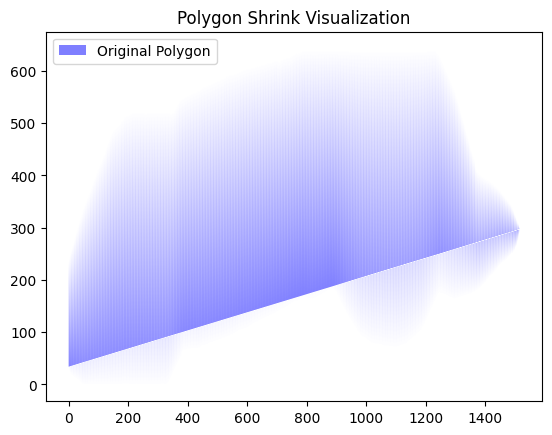

In [8]:
distance = 5
polygon = mask_to_polygon(~mask)
new_polygon = polygon.buffer(distance)


visualize_polygons(polygon, new_polygon)

In [12]:
new_mask = coords_in_poly(list(polygon.exterior.coords), mask.shape)
new_mask

In [ ]:
class QA_QC_main():
    def __init__(self):
        self.ident = '\n'
        self.report_text = "Итоги тестирования:\n"
    
    def get_list_of_tests(self) -> list:
        """
        Метод для получения списка тестов для данных реализованных в классе QA_QC_seismic

        Returns:
            list: список с названиями методов реализующих тесты
        """        
        test_methods = [method for method in dir(self) if
                        callable(getattr(self, method)) and method.startswith("test")]
        return test_methods

    def get_method_description(self, method_name: str) -> str:
        """
        Метод для получение описания теста по его названию

        Args:
            method_name(str) - название теста
        Returns:
            str - описание теста
        """
        method = getattr(self, method_name, None)
        if method is not None:
            return method.__doc__
        else:
            return "Метод не найден."

    def start_tests(self, list_of_tests: list, get_report=True) -> dict:
        """
        Метод который запускает все тесты, которые переданы в виде списка list_of_tests

        Args:
            list_of_tests (list): список названий тестов которые должны быть проведены
            get_report (bool, optional): _description_. Defaults to True.

        Returns:
            dict: результаты выбранных тестов
        """            
        results = {}
        for method_name in list_of_tests:
            method = getattr(self, method_name)
            results[method_name] = method(get_report=get_report)
        return results

    def generate_test_report(self, file_name='test_report', file_path='report', data_name=None):
        """
        Метод для генерации отчета в виде текстового файла

        Args:
            file_name (str, optional): название файла с отчетом. Defaults to 'test_report'.
            file_path (str, optional): директория в которую следует сохранить отчет. Defaults to 'report'.
            data_name (str, optional): название данных который подвергались тестированию. 
                                       Данное название отобразится в итоговом отчете. Defaults to self.file_name.
        """        
        data_name = self.file_name if not data_name else data_name
        timestamp = datetime.datetime.now().strftime("%Y-%m-%d")
        report = f"Отчет о тестировании от {timestamp}{self.ident}Название тестируемого файла: '{data_name}'\n\n{self.report_text} "
        with open(f"{file_path}/{file_name}.txt", "w") as file:
            file.write(report)

In [113]:
import numpy as np
from matplotlib.path import Path
from shapely.geometry import Polygon
from scipy import ndimage
from qa_qc_lib.qa_qc_seismic import QA_QC_seismic
import matplotlib.pyplot as plt
from scipy.signal import convolve2d

def find_border(mask):
    # Создаем 3x3 ядро (kernel) с единицами
    kernel = np.ones((3, 3))

    # Применяем свертку к маске с ядром
    conv_result = convolve2d(mask, kernel, mode='same')

    # Идентифицируем границы: все пиксели в результирующем изображении, которые меньше 9
    # (и соответствующие пиксели в исходной маске равны True), являются границами.
    border = np.logical_and(conv_result < 9, mask)
    
    return border


def compute_variance(arr):
    # Вычисляем среднее значение
    mean_val = np.mean(arr)
    
    # Вычисляем дисперсию
    variance = np.mean((arr - mean_val) ** 2)
    
    return variance



compute_variance(seismic_cube[border_mask])

file_path = 'data/Глубинный куб NP cropped'
seism_data_qa_qc = QA_QC_seismic(file_path=file_path)





In [115]:
from scipy.signal import convolve2d

def find_border(mask):
    # Создаем 3x3 ядро (kernel) с единицами
    kernel = np.ones((3, 3))
    # Применяем свертку к маске с ядром
    conv_result = convolve2d(mask, kernel, mode='same')
    # Идентифицируем границы: все пиксели в результирующем изображении, которые меньше 9
    # (и соответствующие пиксели в исходной маске равны True), являются границами.
    border = np.logical_and(conv_result < 9, mask)
    return border


def compute_variance(arr):
    # Вычисляем среднее значение
    mean_val = np.mean(arr)
    # Вычисляем дисперсию
    variance = np.mean((arr - mean_val) ** 2)
    return variance


# Создаём маску которая будет отражать наличие сейсмотрасс, а значит и геометрию сейсмополя
seismic_cube = seism_data_qa_qc.seismic_cube.copy()
seismic_cube_r = seismic_cube.reshape(-1, seismic_cube.shape[2])
mask = np.all(seismic_cube_r == 0, axis=1)
mask = mask.reshape((seismic_cube.shape[0], seismic_cube.shape[1]))

# Создаём маску которая будет хранить условниые классы (0 - сейсмотрассы отсутствуют, 
#                                                       1 - сейсмотрассы присутствуют / основная часть куба, 
#                                                       2 - сейсмотрассы присутствуют / краевая часть куба )
numeric_mask = (~mask).astype(int)
# Далее итеративно расширяем границы краевой зоны и обсчитываем для неё дисперсию
variance_list = []
while (numeric_mask==1).sum() > 1:    # Условие остановки
    # find_border определяет пиксели/дискреты лежащие на границе полигона, после чего они переклассифицируются в краевую чать куба
    numeric_mask[find_border(numeric_mask==1)] = 2  
    variance = compute_variance(seismic_cube[numeric_mask==2])
    variance_list.append(variance)
    print((numeric_mask==1).sum(), variance)


676659 1617508.8
672047 1720421.2
667457 1807432.1
662881 1884600.1
658317 1949360.9
653764 2013024.6
649229 2075065.0
644705 2137319.0
640193 2200857.5
635691 2263626.0
631198 2326916.2
626717 2387554.8
622250 2441871.5
617792 2492998.5
613343 2543889.5
608903 2593957.8
604475 2644352.8
600060 2692625.2
595655 2737771.0
591260 2779641.8
586876 2818822.2
582504 2857315.0
578141 2894489.5
573787 2930707.8
569443 2966736.2
565107 3001044.5
560783 3032519.0
556469 3062020.8
552166 3088483.8
547873 3113355.0
543591 3137023.2
539321 3159292.5
535065 3181224.5
530817 3202388.2
526580 3222622.2
522352 3241996.2
518135 3259375.0
513930 3275214.0
509734 3289502.0
505548 3303326.2
501373 3317161.2
497209 3330515.2
493056 3343180.2
488914 3354841.5
484786 3364484.0
480669 3373465.5
476562 3381891.5
472465 3389975.2
468380 3398146.0
464307 3406189.0
460244 3413599.2
456192 3420620.2
452151 3426761.5
448122 3432685.0
444107 3438011.8
440103 3442996.2
436111 3448651.8
432127 3454779.0
428157 3460760

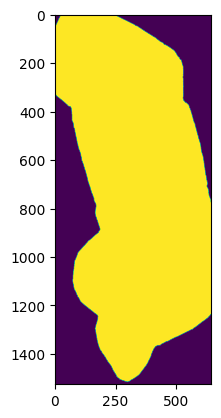

In [116]:
plt.imshow(numeric_mask)
plt.show()

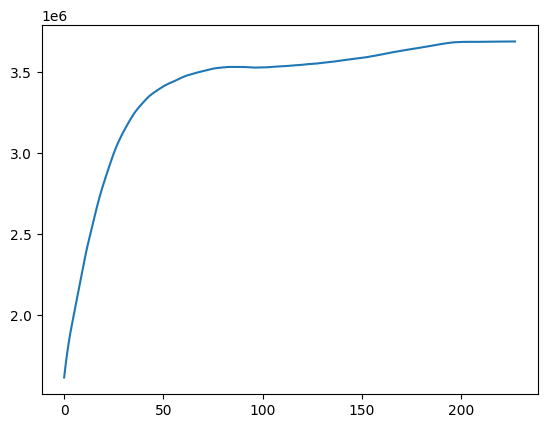

In [118]:
plt.plot(variance_list)
plt.show()

In [205]:
import numpy as np
import matplotlib.pyplot as plt

def compute_variance(arr):
    # Вычисляем среднее значение
    mean_val = np.mean(arr)
    # Вычисляем дисперсию
    variance = np.mean((arr - mean_val) ** 2)
    return variance

def best_split_point(variance_list):
    # Вычисляем производные
    derivatives = np.diff(variance_list)
    
    max_variance_diff = 0
    best_point = 0

    for i in range(1, len(derivatives)):
        left_variance = compute_variance(derivatives[:i])
        right_variance = compute_variance(derivatives[i:])
        
        variance_diff = np.abs(left_variance - right_variance)
        
        if variance_diff > max_variance_diff:
            max_variance_diff = variance_diff
            best_point = i

    return best_point

# Пример использования
split_point = best_split_point(variance_list)

border_mask = (~mask).astype(int)
# Далее итеративно расширяем границы краевой зоны и обсчитываем для неё дисперсию
for i in range(split_point+1):    # Условие остановки
    # find_border определяет пиксели/дискреты лежащие на границе полигона, после чего они переклассифицируются в краевую чать куба
    border_mask[find_border(border_mask==1)] = 2  





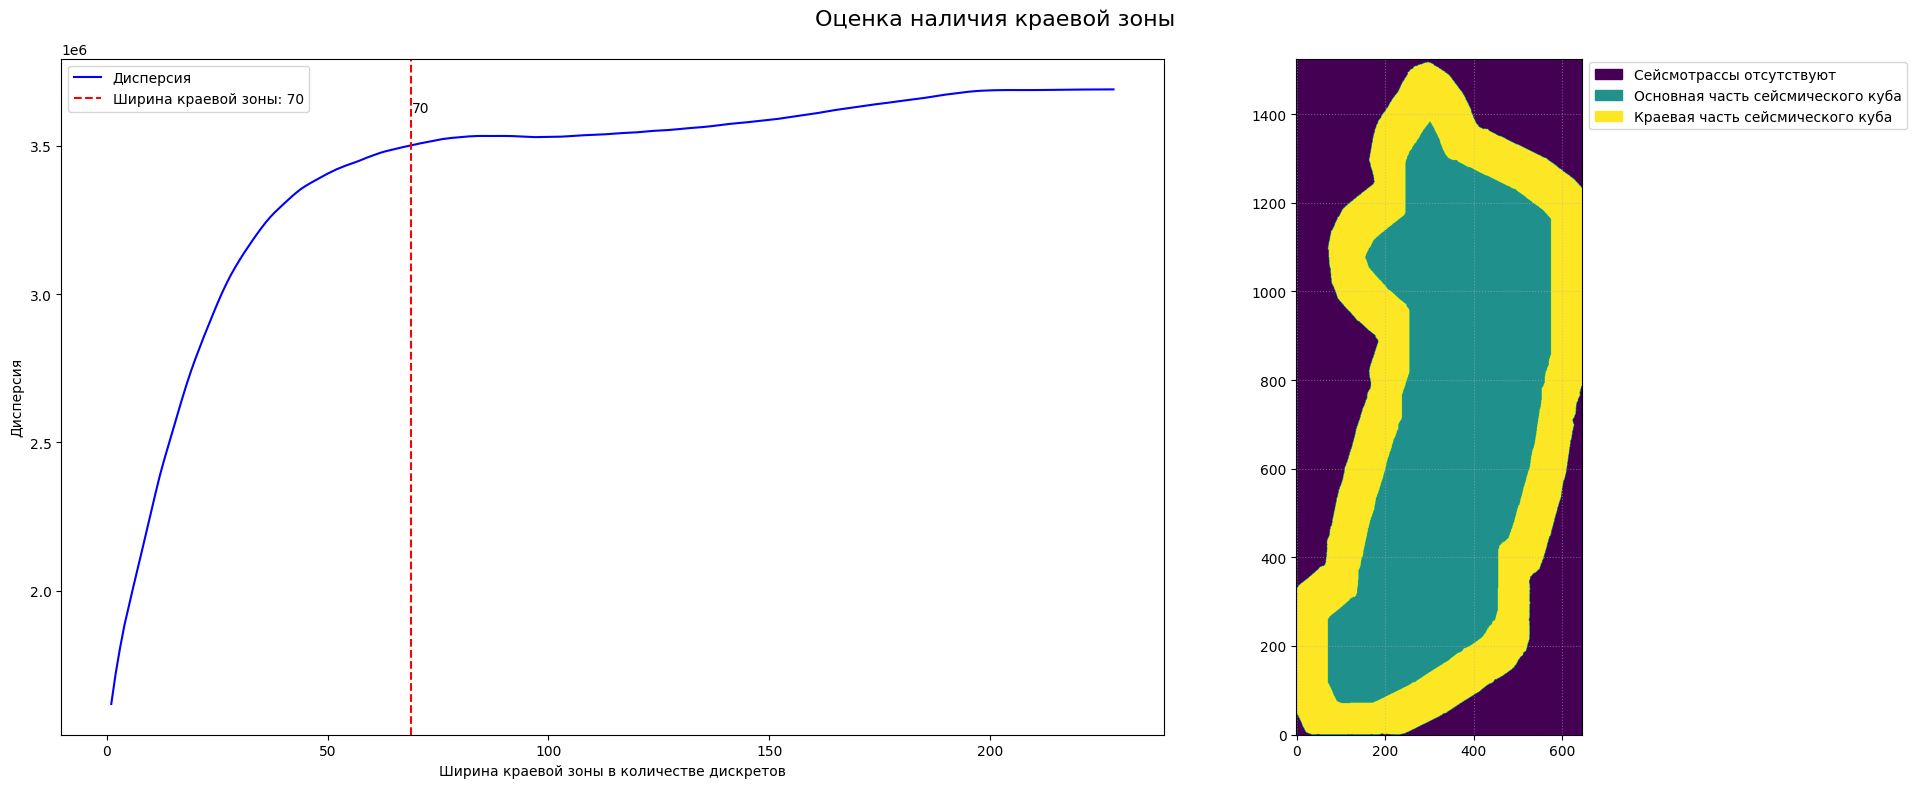

In [229]:

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

def visualize_edge_zone_evaluation(mask, variance_list, split_point):
    """
    Визуализирует оценку наличия краевой зоны на основе маски и списка дисперсий.

    Args:
        mask (numpy.ndarray): Маска, содержащая значения: 
                              0 - Сейсмотрассы отсутствуют
                              1 - Основная часть сейсмического куба
                              2 - Краевая часть сейсмического куба.
        variance_list (list ): Список дисперсий для последовательности.
        split_point (int): Индекс разделения для отсечки краевой зоны.
    """
    fig, axes = plt.subplots(1, 2, figsize=(20, 8), gridspec_kw={'width_ratios': [3, 2]}) 
    # Добавляем общий заголовок для всей фигуры
    fig.suptitle("Оценка наличия краевой зоны", fontsize=16)
    # Визуализация графика дисперсии
    x_vals = np.arange(1, len(variance_list) + 1)  # Начало с 1
    axes[0].plot(x_vals, variance_list, label="Дисперсия", color="blue")
    axes[0].axvline(x=split_point, color="red", linestyle="--", label=f"Ширина краевой зоны: {split_point+1}")
    axes[0].text(split_point, variance_list[split_point-1] + 0.05*(max(variance_list)-min(variance_list)), f"{split_point+1}", color='black', ha="left", va="bottom")
    axes[0].legend()
    axes[0].set_xlabel("Ширина краевой зоны в количестве дискретов")
    axes[0].set_ylabel("Дисперсия")
    
    # Визуализация маски
    im = axes[1].imshow(mask)
    axes[1].grid(ls=':', alpha=.5)
    axes[1].invert_yaxis()
    colors = im.cmap(im.norm(range(3)))
    labels = [
        'Сейсмотрассы отсутствуют',
        'Основная часть сейсмического куба',
        'Краевая часть сейсмического куба'
    ]
    legend_labels = [mpatches.Patch(color=colors[i], label=labels[i]) for i in range(3)]
    axes[1].legend(handles=legend_labels, loc='center left', bbox_to_anchor=(1, 0.945))
    
    # Отображение графиков
    plt.tight_layout()
    plt.show()




visualize_edge_zone_evaluation(border_mask, variance_list, split_point)

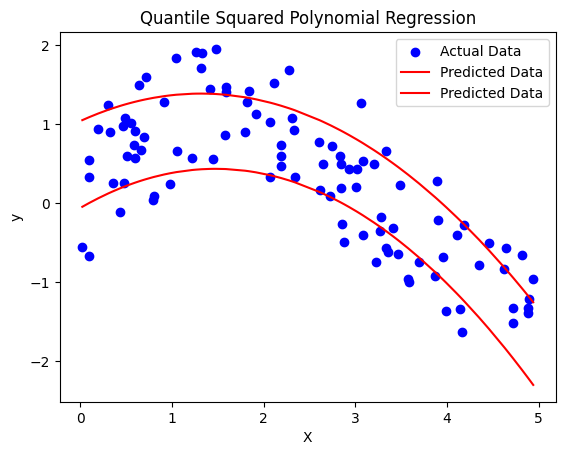

Процент точек ниже кривой: 22.00%


In [9]:
import numpy as np
from scipy.optimize import minimize
from sklearn.preprocessing import PolynomialFeatures
import matplotlib.pyplot as plt

class QuantileSquaredPolynomialRegression:
    
    def __init__(self, tau=0.5, degree=2):
        self.tau = tau
        self.degree = degree
        self.coef_ = None
        self.poly_transform = PolynomialFeatures(degree=self.degree, include_bias=False)
    
    def _loss(self, beta, X, y, tau):
        y_pred = X @ beta
        residuals = y - y_pred
        loss = np.where(residuals >= 0, tau * residuals**2, (1 - tau) * residuals**2)
        return np.sum(loss)
    
    def fit(self, X, y):
        X_poly = self.poly_transform.fit_transform(X)
        X_ = np.hstack([np.ones((X_poly.shape[0], 1)), X_poly])
        initial_beta = np.zeros(X_.shape[1])
        result = minimize(self._loss, initial_beta, args=(X_, y, self.tau))
        self.coef_ = result.x
        
    def predict(self, X):
        if self.coef_ is None:
            raise ValueError("The model is not trained yet. Use the `fit` method first.")
        X_poly = self.poly_transform.transform(X)
        X_ = np.hstack([np.ones((X_poly.shape[0], 1)), X_poly])
        return X_ @ self.coef_

# Генерация данных
np.random.seed(0)
X = np.sort(5 * np.random.rand(100, 1), axis=0)
y = np.sin(X).ravel() + np.random.normal(0, 0.5, X.shape[0])

# Обучение модели и предсказание
model = QuantileSquaredPolynomialRegression(tau=0.9)
model.fit(X, y)
predictions = model.predict(X)

# Визуализация
plt.scatter(X, y, color='blue', label="Actual Data")
plt.plot(X, predictions, color='red', label="Predicted Data")

# Обучение модели и предсказание
model = QuantileSquaredPolynomialRegression(tau=0.1)
model.fit(X, y)
predictions = model.predict(X)
plt.plot(X, predictions, color='red', label="Predicted Data")

plt.legend()
plt.xlabel('X')
plt.ylabel('y')
plt.title('Quantile Squared Polynomial Regression')
plt.show()

# Вычисление процента точек, лежащих ниже кривой
below_curve = np.sum(y < predictions)
percent_below_curve = (below_curve / len(y)) * 100

print(f"Процент точек ниже кривой: {percent_below_curve:.2f}%")



Процент точек ниже кривой: 87.00%


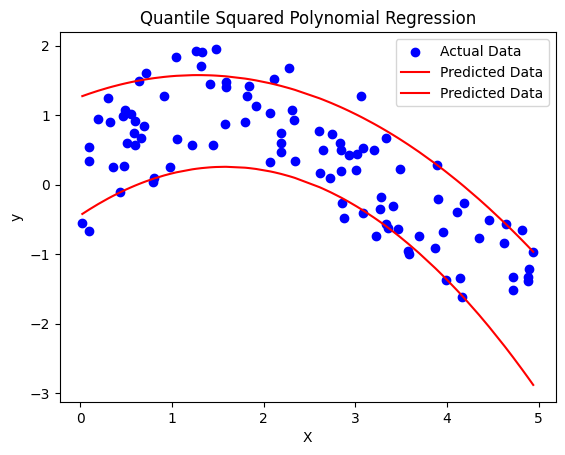

Процент точек ниже кривой: 13.00%


In [18]:
class QuantileSquaredPolynomialRegression:
    
    def __init__(self, tau=0.5, degree=2, alpha=0.5):
        self.tau = tau
        self.degree = degree
        self.alpha = alpha  # коэффициент регуляризации
        self.coef_ = None
        self.poly_transform = PolynomialFeatures(degree=self.degree, include_bias=False)
    
    def _loss(self, beta, X, y, tau, alpha):
        y_pred = X @ beta
        residuals = y - y_pred
        linear_loss = np.where(residuals >= 0, tau * residuals, (1 - tau) * (-residuals))
        squared_loss = np.where(residuals >= 0, tau * residuals**2, (1 - tau) * residuals**2)
        total_loss = linear_loss + alpha * squared_loss
        return np.sum(total_loss)
    
    def fit(self, X, y):
        X_poly = self.poly_transform.fit_transform(X)
        X_ = np.hstack([np.ones((X_poly.shape[0], 1)), X_poly])
        initial_beta = np.zeros(X_.shape[1])
        result = minimize(self._loss, initial_beta, args=(X_, y, self.tau, self.alpha))
        self.coef_ = result.x
        
    def predict(self, X):
        if self.coef_ is None:
            raise ValueError("The model is not trained yet. Use the `fit` method first.")
        X_poly = self.poly_transform.transform(X)
        X_ = np.hstack([np.ones((X_poly.shape[0], 1)), X_poly])
        return X_ @ self.coef_


# Генерация данных
np.random.seed(0)
X = np.sort(5 * np.random.rand(100, 1), axis=0)
y = np.sin(X).ravel() + np.random.normal(0, 0.5, X.shape[0])

alpha = 0.2

# Обучение модели и предсказание
model = QuantileSquaredPolynomialRegression(tau=0.9, alpha=alpha)
model.fit(X, y)
predictions = model.predict(X)

# Вычисление процента точек, лежащих ниже кривой
below_curve = np.sum(y < predictions)
percent_below_curve = (below_curve / len(y)) * 100
print(f"Процент точек ниже кривой: {percent_below_curve:.2f}%")

# Визуализация
plt.scatter(X, y, color='blue', label="Actual Data")
plt.plot(X, predictions, color='red', label="Predicted Data")


# Обучение модели и предсказание
model = QuantileSquaredPolynomialRegression(tau=0.1, alpha=alpha)
model.fit(X, y)
predictions = model.predict(X)
plt.plot(X, predictions, color='red', label="Predicted Data")

plt.legend()
plt.xlabel('X')
plt.ylabel('y')
plt.title('Quantile Squared Polynomial Regression')
plt.show()

# Вычисление процента точек, лежащих ниже кривой
below_curve = np.sum(y < predictions)
percent_below_curve = (below_curve / len(y)) * 100

print(f"Процент точек ниже кривой: {percent_below_curve:.2f}%")

Процент точек ниже кривой: 86.00%


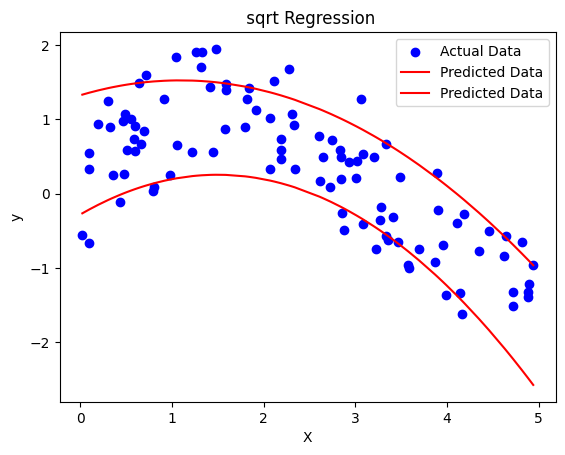

Процент точек ниже кривой: 15.00%


In [27]:
import numpy as np
from scipy.optimize import minimize
from sklearn.preprocessing import PolynomialFeatures
import matplotlib.pyplot as plt

class QuantileCustomFunctionRegression:
    
    def __init__(self, tau=0.5, function_type="polynomial", degree=2, alpha=0.5):
        self.tau = tau
        self.function_type = function_type
        self.degree = degree
        self.alpha = alpha  # коэффициент регуляризации
        self.coef_ = None
        self.poly_transform = PolynomialFeatures(degree=self.degree, include_bias=True)
    
    def transform_input(self, X):
        if self.function_type == "polynomial":
            return self.poly_transform.fit_transform(X)
        elif self.function_type == "log":
            return np.log(X + 1e-10)
        elif self.function_type == "sqrt":
            return np.sqrt(X)
        elif self.function_type == "exp":
            return np.exp(0.01 * X)  # we multiply by 0.01 to ensure that exp doesn't explode
        elif self.function_type == "power":
            return np.power(X, 0.5)
        else:
            raise ValueError(f"Unsupported function type: {self.function_type}")
    
    def _loss(self, beta, X, y, tau, alpha):
        y_pred = X @ beta
        residuals = y - y_pred
        linear_loss = np.where(residuals >= 0, tau * residuals, (1 - tau) * (-residuals))
        squared_loss = np.where(residuals >= 0, tau * residuals**2, (1 - tau) * residuals**2)
        total_loss = linear_loss + alpha * squared_loss
        return np.sum(total_loss)
    
    def fit(self, X, y):
        X_transformed = self.transform_input(X)
        X_ = np.hstack([np.ones((X_transformed.shape[0], 1)), X_transformed])
        initial_beta = np.zeros(X_.shape[1])
        result = minimize(self._loss, initial_beta, args=(X_, y, self.tau, self.alpha))
        self.coef_ = result.x
        
    def predict(self, X):
        if self.coef_ is None:
            raise ValueError("The model is not trained yet. Use the `fit` method first.")
        X_transformed = self.transform_input(X)
        X_ = np.hstack([np.ones((X_transformed.shape[0], 1)), X_transformed])
        return X_ @ self.coef_


# Генерация данных
np.random.seed(0)
X = np.sort(5 * np.random.rand(100, 1), axis=0)
y = np.sin(X).ravel() + np.random.normal(0, 0.5, X.shape[0])

alpha = 0.5

# Обучение модели и предсказание
model = QuantileSquaredPolynomialRegression(tau=0.9, alpha=alpha)
model.fit(X, y)
predictions = model.predict(X)

# Вычисление процента точек, лежащих ниже кривой
below_curve = np.sum(y < predictions)
percent_below_curve = (below_curve / len(y)) * 100
print(f"Процент точек ниже кривой: {percent_below_curve:.2f}%")

# Визуализация
plt.scatter(X, y, color='blue', label="Actual Data")
plt.plot(X, predictions, color='red', label="Predicted Data")


# Обучение модели и предсказание
model = QuantileSquaredPolynomialRegression(tau=0.1, alpha=alpha)
model.fit(X, y)
predictions = model.predict(X)
plt.plot(X, predictions, color='red', label="Predicted Data")

plt.legend()
plt.xlabel('X')
plt.ylabel('y')
plt.title(' sqrt Regression')
plt.show()

# Вычисление процента точек, лежащих ниже кривой
below_curve = np.sum(y < predictions)
percent_below_curve = (below_curve / len(y)) * 100

print(f"Процент точек ниже кривой: {percent_below_curve:.2f}%")

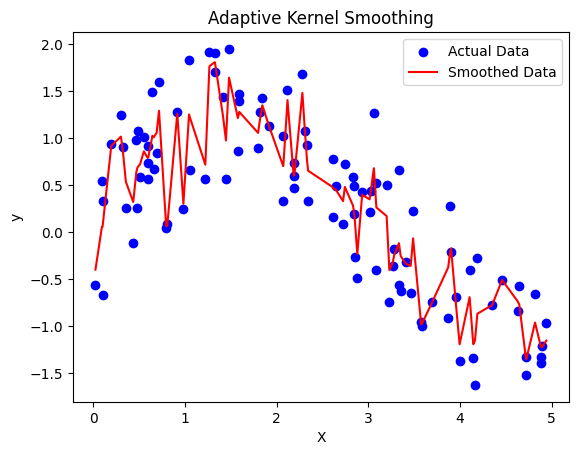

In [28]:
import numpy as np
import matplotlib.pyplot as plt

def gaussian_kernel(x, xi, h):
    """Гауссова функция ядра."""
    return np.exp(-0.5 * ((x - xi) / h) ** 2)

def adaptive_bandwidth(X, base_bandwidth):
    """Адаптивная ширина окна."""
    density = np.zeros_like(X)
    for i, xi in enumerate(X):
        density[i] = np.sum(gaussian_kernel(X, xi, base_bandwidth))
    return base_bandwidth / density

def adaptive_kernel_smoothing(X, y, base_bandwidth=1.0):
    """Сглаживание с адаптивной шириной окна."""
    y_smoothed = np.zeros_like(y)
    h_adaptive = adaptive_bandwidth(X, base_bandwidth)
    
    for i, xi in enumerate(X):
        weights = gaussian_kernel(X, xi, h_adaptive[i])
        y_smoothed[i] = np.sum(weights * y) / np.sum(weights)
    return y_smoothed

# Генерация данных
np.random.seed(0)
X = np.sort(5 * np.random.rand(100, 1), axis=0)
y = np.sin(X).ravel() + np.random.normal(0, 0.5, X.shape[0])

# Адаптивное сглаживание
y_smoothed = adaptive_kernel_smoothing(X.ravel(), y)

plt.scatter(X, y, color='blue', label="Actual Data")
plt.plot(X, y_smoothed, color='red', label="Smoothed Data")
plt.legend()
plt.xlabel('X')
plt.ylabel('y')
plt.title('Adaptive Kernel Smoothing')
plt.show()

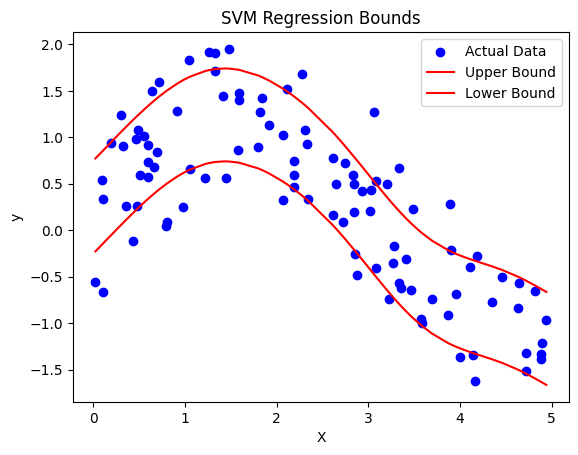

In [49]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVR

# Генерация данных
np.random.seed(0)
X = np.sort(5 * np.random.rand(100, 1), axis=0)
y = np.sin(X).ravel() + np.random.normal(0, 0.5, X.shape[0])

# Обучение модели SVR
model_upper = SVR(C=1.0, epsilon=0.2)
model_lower = SVR(C=1.0, epsilon=0.2)

model_upper.fit(X, y + 0.5)  # Сдвигаем данные вверх для обучения верхней границы
model_lower.fit(X, y - 0.5)  # Сдвигаем данные вниз для обучения нижней границы

y_pred_upper = model_upper.predict(X)
y_pred_lower = model_lower.predict(X)

plt.scatter(X, y, color='blue', label="Actual Data")
plt.plot(X, y_pred_upper, color='red', label="Upper Bound")
plt.plot(X, y_pred_lower, color='red', label="Lower Bound")
#plt.fill_between(X.ravel(), y_pred_lower, y_pred_upper, color='red', alpha=0.3, label="Confidence Interval")
plt.legend()
plt.xlabel('X')
plt.ylabel('y')
plt.title('SVM Regression Bounds')
plt.show()


In [ ]:
def test_surfaces_values_validation(self, get_report=True) -> dict:
    """
    Описанный ранее docstring
    """
    all_results_dict = {}

    if not self._data_availability():
        all_results_dict['data availability'] = False
        self._update_report("Отсутствуют данные для проведения теста.\nДанные о поверхностях не были переданы", get_report)
    else:
        all_results_dict['data availability'] = True
        for path in self.surfaces_path_list:
            name = path.split('/')[-1]
            all_results_dict[name] = self._test_single_surface(name, path, get_report)

    return all_results_dict | {"date": datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")}

def _data_availability(self) -> bool:
    return bool(self.surfaces_path_list)

def _update_report(self, report_text, get_report):
    timestamp = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    self.report_text += f"{timestamp:10} / test_surfaces_values_validation:\n{self.ident}{report_text}\n\n"
    if get_report: 
        print('\n' + report_text)

def _test_single_surface(self, name, path, get_report) -> dict:
    results_dict = {}
    try:
        map_df, inside_polygon, inside_depth_range = self._process_surface_data(path)
        results_dict = self._evaluate_surface_data(map_df, name, inside_polygon, inside_depth_range, get_report)
    except FileNotFoundError: 
        self._update_report(f'Отсутствуют данные для проведения теста.\nНекорректный путь к файлу:"{path}"', get_report)
        results_dict['x_y_coords_validation'], results_dict['z_coords_validation'] = 'Fail', 'Fail'
    
    return results_dict

def _process_surface_data(self, path):
    map_df, _ = self.__open_irap_ascii_grid(path)
    inside_polygon = map_df.apply(lambda row: Point(row['X'], row['Y']).within(self.cube_poly), axis=1)
    inside_depth_range = (map_df['Dept'] >= self.coordinate_z.min()) & (map_df['Dept'] <= self.coordinate_z.min())
    
    return map_df, inside_polygon, inside_depth_range

def _evaluate_surface_data(self, map_df, name, inside_polygon, inside_depth_range, get_report) -> dict:
    results_dict = {}
    # Проверка координат поверхности
    if not inside_polygon.all():
        print("ВНИМАНИЕ! Часть точек поверхности выходит за пределы сейсмического куба по X, Y!")
    if not inside_depth_range.all():
        print("ВНИМАНИЕ! Найдены точки вне заданного диапазона глубины!")
    map_df = map_df[inside_polygon & inside_depth_range]

    # Если нет данных для анализа
    if map_df.empty:
        result_text = f'отражающий горизонт {name} не попадает в границы сейсмического куба'
        self._update_report(result_text, get_report)
        results_dict['result'] = False
        results_dict['slise_map'] = map_df
    else:
        results_dict = self._analyze_surface_values(map_df, name, get_report)

    return results_dict

def _analyze_surface_values(self, map_df, name, get_report) -> dict:
    # ... (как в вашем коде)

    return {
        'result': test_result,
        'slise_map': map_df
    }


In [51]:
import pandas as pd

# Пример данных
names = ["карта1", "карта2", "карта3"]
dataframes = [
    pd.DataFrame({'X': [1, 2, 3], 'Y': [1, 2, 3], 'Dept': [10, 20, 30]}),
    pd.DataFrame({'X': [1, 2, 3], 'Y': [1, 2, 3], 'Dept': [8, 18, 32]}),
    pd.DataFrame({'X': [1, 2, 3], 'Y': [1, 2, 3], 'Dept': [5, 17, 28]})
]

for i in range(1, len(dataframes)):
    merged = dataframes[i].merge(dataframes[i - 1], on=['X', 'Y'], how='inner', suffixes=('_curr', '_prev'))
    # Интерполяция для учета того, что координаты могут не совпадать точно
    merged.interpolate(inplace=True)
    non_conformity = merged[merged['Dept_curr'] > merged['Dept_prev']]
    if not non_conformity.empty:
        percent_mismatch = (non_conformity.shape[0] / merged.shape[0]) * 100
        print(f'Нижележащая структурная карта "{names[i]}" оказалась выше вышележащей структурной карты "{names[i-1]}" (несоответствие на {percent_mismatch:.2f}% площади)')


Нижележащая структурная карта "карта2" оказалась выше вышележащей структурной карты "карта1" (несоответствие на 33.33% площади)
